In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, 
    # normalized to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    try :
        audio, _ = tf.audio.decode_wav(contents=audio_binary)
    except :
        return None
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [12]:
DATA_PATH = "../data/"
TARGETS = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "unknown", "bg_noise"]

In [6]:
model = tf.keras.models.load_model("../models/model_cnn.h5")

2023-01-31 15:52:51.190202: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-31 15:52:51.190251: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-31 15:52:51.190268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Student-laptop): /proc/driver/nvidia/version does not exist
2023-01-31 15:52:51.190511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model.summary()

1/1 [==============================] - 0s 32ms/step


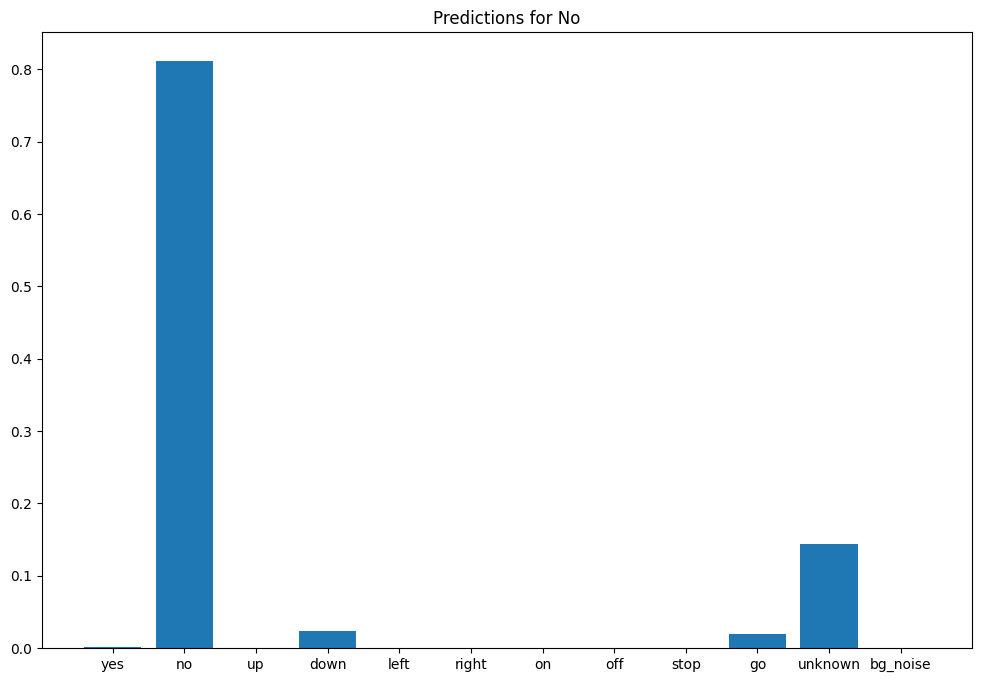

In [13]:
sample_file = DATA_PATH + "no/" + "eb67fcbc_nohash_2.wav"
label = 'no'
sample_data = get_spectrogram(decode_audio(tf.io.read_file(sample_file)))
sample_data_tensor = tf.convert_to_tensor(sample_data)
sample_data_tensor = tf.expand_dims(sample_data_tensor, 0)
sample_data_tensor = np.array(sample_data_tensor.numpy())
prediction = model.predict(sample_data_tensor)
plt.figure(figsize=(12, 8))
plt.bar(TARGETS, tf.nn.softmax(prediction[0]))
plt.title(f'Predictions for No')
plt.show()